In [20]:
import pandas as pd
import polars as pl
import numpy as np
import clickhouse_connect as connect
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import TimeSeriesSplit, train_test_split
from sklearn.metrics import roc_auc_score
import seaborn as sns
from catboost import CatBoostClassifier

In [2]:
params = {
    'host': 'localhost',
    'port': '8123',
    'username': 'default',
    'password': 'default',
    'database': 'db_1'
}

client = connect.get_client(**params)

In [3]:
split_date = '2019-11-01'

In [4]:
query = f'''
select 
user_id,

countIf(event_time < '{split_date}') as event_count,
uniqIf(user_session, event_time < '{split_date}') as session_count,

countIf(event_type = 'view' and event_time < '{split_date}') as view_count,
countIf(event_type = 'cart' and event_time < '{split_date}') as cart_count,
countIf(event_type = 'purchase' and event_time < '{split_date}') as purchase_count,

sumIf(price, event_type = 'purchase' and event_time < '{split_date}') as total_spend,

dateDiff('day', maxIf(event_time, event_time < '{split_date}'), toDateTime('{split_date}')) as days_since_last_event,

arrayElement(topK(1)(if(event_time < '{split_date}', category_code, null)), 1) as fav_category_past,
arrayElement(topK(1)(if(event_time < '{split_date}', brand, null)), 1) as fav_brand_past,

if(countIf(event_type = 'purchase' 
               AND event_time >= '{split_date}' 
               AND event_time < toDateTime('{split_date}') + INTERVAL 7 DAY) > 0, 1, 0) as purchase_next_7d
from raw_opt
group by user_id
having event_count > 0
'''

In [5]:
df = client.query_df(query)
df.head()

,user_id,event_count,session_count,view_count,cart_count,purchase_count,total_spend,days_since_last_event,fav_category_past,fav_brand_past,purchase_next_7d
0,523739882,63,7,63,0,0,0.0,1,,,0
1,514078471,159,14,159,0,0,0.0,9,,,0
2,565972778,1,1,1,0,0,0.0,1,,philips,0
3,555786755,22,3,22,0,0,0.0,22,electronics.smartphone,samsung,0
4,563644716,1,1,1,0,0,0.0,8,electronics.smartphone,samsung,0


In [6]:
df['fav_brand_past'] = df['fav_brand_past'].replace('', 'unknown')
df['fav_category_past'] = df['fav_category_past'].replace('', 'unknown')
df.shape

(3022290, 11)

In [8]:
df[df['purchase_next_7d'] == 1].shape

(70155, 11)

In [14]:
sample = df[df['purchase_next_7d'] == 0].sample(frac=0.10)
sample = pd.concat([sample, df[df['purchase_next_7d'] == 1]], axis=0, ignore_index=True)
sample.shape

(365369, 11)

In [16]:
sample_train, sample_test = train_test_split(sample, test_size=0.1, random_state=42, shuffle=False)

In [18]:
X_train = sample_train.drop('purchase_next_7d', axis=1)
y_train = sample_train['purchase_next_7d']
X_test = sample_test.drop('purchase_next_7d', axis=1)
y_test = sample_test['purchase_next_7d']
cat_cols = ['fav_category_past', 'fav_brand_past']

In [19]:
model = CatBoostClassifier(cat_features=cat_cols, iterations=400)
model.fit(X_train, y_train)

Learning rate set to 0.283526
0:	learn: 0.4400946	total: 469ms	remaining: 3m 7s
1:	learn: 0.3404249	total: 700ms	remaining: 2m 19s
2:	learn: 0.2987246	total: 934ms	remaining: 2m 3s
3:	learn: 0.2787101	total: 1.2s	remaining: 1m 58s
4:	learn: 0.2705770	total: 1.45s	remaining: 1m 54s
5:	learn: 0.2651780	total: 1.68s	remaining: 1m 50s
6:	learn: 0.2623752	total: 1.91s	remaining: 1m 47s
7:	learn: 0.2608853	total: 2.16s	remaining: 1m 45s
8:	learn: 0.2596951	total: 2.4s	remaining: 1m 44s
9:	learn: 0.2592321	total: 2.76s	remaining: 1m 47s
10:	learn: 0.2584139	total: 3.02s	remaining: 1m 46s
11:	learn: 0.2576862	total: 3.24s	remaining: 1m 44s
12:	learn: 0.2574004	total: 3.46s	remaining: 1m 43s
13:	learn: 0.2569739	total: 3.69s	remaining: 1m 41s
14:	learn: 0.2567691	total: 3.92s	remaining: 1m 40s
15:	learn: 0.2564376	total: 4.16s	remaining: 1m 39s
16:	learn: 0.2562243	total: 4.39s	remaining: 1m 38s
17:	learn: 0.2561342	total: 4.79s	remaining: 1m 41s
18:	learn: 0.2559765	total: 5.09s	remaining: 1m 

In [23]:
roc_auc_score(y_train.values, model.predict_proba(X_train)[:, 1])

0.8328210424550283

In [24]:
roc_auc_score(y_test.values, model.predict_proba(X_test)[:, 1])

d:\eCommerce\venv\Lib\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


nan

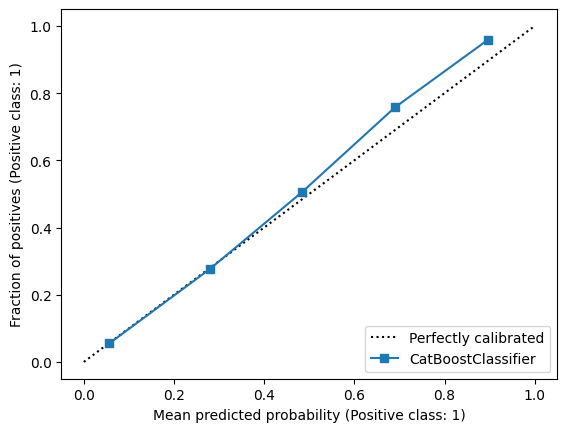

In [26]:
from sklearn.calibration import calibration_curve
from sklearn.calibration import CalibrationDisplay

CalibrationDisplay.from_estimator(model, X_train, y_train)

In [36]:
sample[sample['purchase_next_7d'] == 1].shape[0] / sample.shape[0] * 100

19.20113638540763

In [65]:
ts_split = TimeSeriesSplit(n_splits=4, test_size=sample.shape[0] // 8)
scores = []
for i, (train_index, test_index) in enumerate(ts_split.split(sample)):
    print(f'fold {i}')
    model = CatBoostClassifier(cat_features=cat_cols, iterations=400)
    train = sample.iloc[train_index]
    unique_classes = train['purchase_next_7d'].nunique()
    
    if unique_classes < 2:
        print(f"  Skip fold {i}: Train contains only {unique_classes} unique class(es).")
        continue
    test = sample.iloc[test_index]
    model.fit(train.drop('purchase_next_7d', axis=1), train['purchase_next_7d'])
    scores.append(roc_auc_score(test['purchase_next_7d'], model.predict_proba(test.drop('purchase_next_7d', axis=1))[:, 1]))

np.mean(scores)

fold 0
  Skip fold 0: Train contains only 1 unique class(es).
fold 1
  Skip fold 1: Train contains only 1 unique class(es).
fold 2
  Skip fold 2: Train contains only 1 unique class(es).
fold 3
Learning rate set to 0.280136
0:	learn: 0.4092689	total: 292ms	remaining: 1m 56s
1:	learn: 0.3043481	total: 521ms	remaining: 1m 43s
2:	learn: 0.2577194	total: 752ms	remaining: 1m 39s
3:	learn: 0.2363103	total: 981ms	remaining: 1m 37s
4:	learn: 0.2258033	total: 1.24s	remaining: 1m 38s
5:	learn: 0.2207380	total: 1.51s	remaining: 1m 39s
6:	learn: 0.2181515	total: 1.73s	remaining: 1m 37s
7:	learn: 0.2162558	total: 1.96s	remaining: 1m 36s
8:	learn: 0.2153241	total: 2.24s	remaining: 1m 37s
9:	learn: 0.2145829	total: 2.46s	remaining: 1m 36s
10:	learn: 0.2142542	total: 2.7s	remaining: 1m 35s
11:	learn: 0.2137611	total: 3s	remaining: 1m 36s
12:	learn: 0.2135027	total: 3.22s	remaining: 1m 35s
13:	learn: 0.2133350	total: 3.44s	remaining: 1m 34s
14:	learn: 0.2131159	total: 3.71s	remaining: 1m 35s
15:	learn: 

d:\eCommerce\venv\Lib\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


np.float64(nan)